Reports submitted by aircraft owners, operators, and maintenance personnel to the FAA regarding problems encountered with aircraft and aircraft equipment. It includes data on the types of failures and the corrective actions taken

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load the file
df = pd.read_csv('Airline Occurences.csv')

In [3]:
df.head()

,Report,Part Failure,Occurence Nature condition,Occurence Precautionary Procedures
0,MECHANICAL / LANDING GEAR GND FAIL MSG AFTER T...,RT MLG BRAKE DAMAGED,WARNING INDICATION,OTHER
1,THE NOSE LANDING GEAR DID NOT EXTEND FULLY DUR...,ZONE 700 MALFUNCTIONED,WARNING INDICATION,ABORTED APPROACH
2,THE LEFT SIDE HYDRAULIC SYSTEM FILTER BOWL ASS...,HYD FILTER FAILED,OTHER,ABORTED APPROACH
3,AIRCRAFT WAS ON ROLLOUT DURING A NORMAL LANDIN...,LEFT COLLAPSED,OTHER,OTHER
4,UPON TAKEOFF ROLL BUT PRIOR TO REACHING 80 KNO...,ZONE 600 CRACKED,WARNING INDICATION,ABORTED TAKEOFF


In [4]:
# Data stats
df.describe()

,Report,Part Failure,Occurence Nature condition,Occurence Precautionary Procedures
count,100028,100028,100028,100028
unique,98013,25088,22,14
top,AIRCRAFT WAS GROUNDED: BIRD STRIKE IN NUMBER 2...,FUSELAGE CRACKED,OTHER,NONE
freq,30,1998,82172,79268


## EDA

In [5]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100028 entries, 0 to 100027
Data columns (total 4 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Report                              100028 non-null  object
 1   Part Failure                        100028 non-null  object
 2   Occurence Nature condition          100028 non-null  object
 3   Occurence Precautionary Procedures  100028 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [6]:
# Check the number of missing values in each column
print(df.isnull().sum())

Report                                0
Part Failure                          0
Occurence Nature condition            0
Occurence Precautionary Procedures    0
dtype: int64


In [7]:
# Check the number of unique values in each column
print(df.nunique())

Report                                98013
Part Failure                          25088
Occurence Nature condition               22
Occurence Precautionary Procedures       14
dtype: int64


In [8]:
# Remove leading and trailing whitespace in all features
df['Report'] = df['Report'].str.strip()
df['Part Failure'] = df['Part Failure'].str.strip()
df['Occurence Nature condition'] = df['Occurence Nature condition'].str.strip()
df['Occurence Precautionary Procedures'] = df['Occurence Precautionary Procedures'].str.strip()

## Target Variable

In [9]:
df['Occurence Nature condition'].value_counts()

OTHER                         82172
WARNING INDICATION             7154
NO TEST                        3577
SMOKE/FUMES/ODORS/SPARKS       2166
FALSE WARNING                  1683
FLUID LOSS                      975
FLT CONT AFFECTED               320
OVER TEMP                       316
NO WARNING INDICATION           255
VIBRATION/BUFFET                228
INADEQUATE Q C                  223
AFFECT SYSTEMS                  202
F.O.D.                          191
PARTIAL RPM/PWR LOSS            152
MULTIPLE FAILURE                107
FLAME/FIRE                       65
ENGINE STOPPAGE                  56
SIGNIFICANT FAILURE REPORT       53
INFLIGHT SEPARATION              47
ENGINE FLAMEOUT                  38
ELECT. POWER LOSS-50 PC          27
FLT. ATTITUDE INST.              21
Name: Occurence Nature condition, dtype: int64

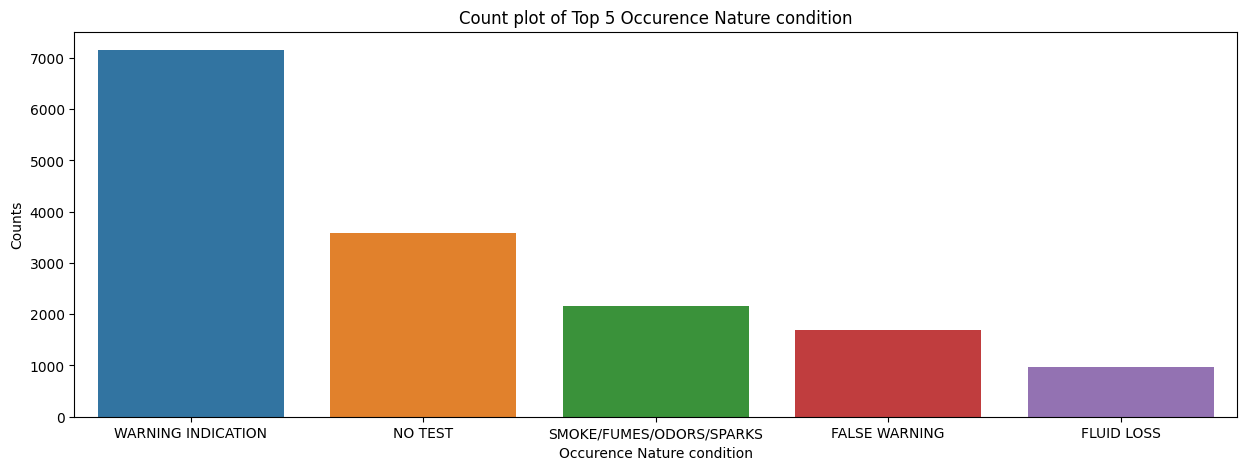

In [10]:
# Count the frequency of each unique value in the 'Occurence Nature condition' column
nature_counts = df['Occurence Nature condition'].value_counts()

# Plot a histogram of the 'Part Failure' column
fig = plt.figure(figsize = (15, 5))

# Top 5 Occurence Nature condition 
top_nature_counts = nature_counts[nature_counts.index != 'OTHER'][:5]
sns.barplot(x = top_nature_counts.index, y = top_nature_counts.values)
plt.title('Count plot of Top 5 Occurence Nature condition')
plt.xlabel('Occurence Nature condition')
plt.ylabel('Counts')
plt.show()

## Occurence Precautionary Procedures

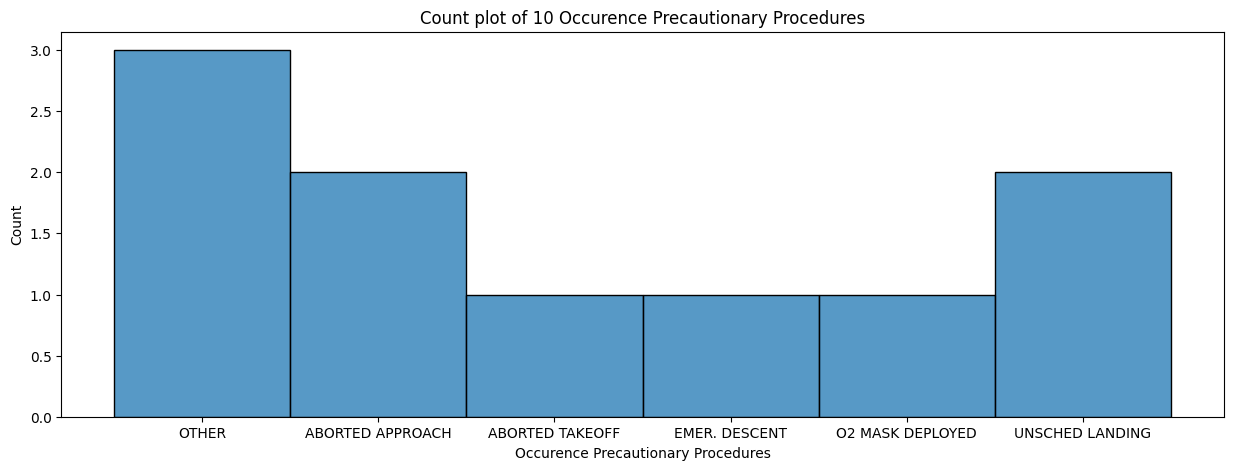

In [11]:
# Plot a histogram of the 'Part Failure' column
fig = plt.figure(figsize=(15, 5))
sns.histplot(df['Occurence Precautionary Procedures'].head(10))
plt.title('Count plot of 10 Occurence Precautionary Procedures')
plt.show()

In [12]:
df['Occurence Precautionary Procedures'].value_counts()

NONE                        79268
OTHER                       14855
UNSCHED LANDING              3627
ABORTED TAKEOFF               719
RETURN TO BLOCK               556
EMER. DESCENT                 422
ENGINE SHUTDOWN               229
ABORTED APPROACH              142
DEACTIVATE SYST/CIRCUITS      135
DUMP FUEL                      25
ACTIVATE FIRE EXT.             22
O2 MASK DEPLOYED               21
AUTOROTATION                    4
CABIN DEPRESSURIZATION          3
Name: Occurence Precautionary Procedures, dtype: int64

NONE is indicating there are Null Value 

In [13]:
df.loc[df['Occurence Precautionary Procedures'] == 'NONE']

,Report,Part Failure,Occurence Nature condition,Occurence Precautionary Procedures
10,INDICATION OF CRACK/DEFECT DETECTED WHICH EXCE...,RT WING CRACKED,OTHER,NONE
11,DURING A SCHEDULED VISUAL INSPECTION OF THE EN...,ENGINE LEAKING,FLUID LOSS,NONE
12,"DURING A SCHEDULED VISUAL INSPECTION, A CRACK ...",RUDDER CRACKED,OTHER,NONE
13,DURING A SCHEDULED MAINTENANCE INSPECTION OF T...,ENGINE LEAKING,FLUID LOSS,NONE
14,DURING A SCHEDULED MAINTENANCE INSPECTION OF T...,ENGINE LEAKING,FLUID LOSS,NONE
...,...,...,...,...
100021,"FLT#2120, SAN-BOS. 'EMERGENCY EXIT LIGHT 2L AN...",12WL FAILED,OTHER,NONE
100022,"FLT#640, CLE-BOS. 'R-1 DOOR SLIDE BLOWN; REMOV...",R1-SLIDE DEPLOYED,OTHER,NONE
100023,"FLT#1075, PVD-MCO. ' DESCENT FROM FL 350, AT F...",NONE NONE,SMOKE/FUMES/ODORS/SPARKS,NONE
100025,"FLT#1134, SJU-MCO. ' EMERGENCY LIGHTS TEST FAI...",7501MM FAILED,OTHER,NONE


In [14]:
# Length of the dataset where No Occurence Precautionary Procedures action taken
len(df.loc[df['Occurence Precautionary Procedures'] == 'NONE'])

79268

In [15]:
# Data where some Occurence Precautionary Procedures are taken
df_OPP = df.loc[(df['Occurence Precautionary Procedures'] != 'NONE') & (df['Occurence Precautionary Procedures'] != 'OTHER')]
df_OPP.head(6)

,Report,Part Failure,Occurence Nature condition,Occurence Precautionary Procedures
1,THE NOSE LANDING GEAR DID NOT EXTEND FULLY DUR...,ZONE 700 MALFUNCTIONED,WARNING INDICATION,ABORTED APPROACH
2,THE LEFT SIDE HYDRAULIC SYSTEM FILTER BOWL ASS...,HYD FILTER FAILED,OTHER,ABORTED APPROACH
4,UPON TAKEOFF ROLL BUT PRIOR TO REACHING 80 KNO...,ZONE 600 CRACKED,WARNING INDICATION,ABORTED TAKEOFF
6,75 AMP EMERGENCY BATTERY CIRCUIT BREAKER ON CO...,EMER BATTERY FAILED,ELECT. POWER LOSS-50 PC,EMER. DESCENT
7,"CREW SMELLED AN ODOR, TOOK ACTIONS TO ISOLATE ...",REAR CABIN BAGGA BURNED OUT,SMOKE/FUMES/ODORS/SPARKS,O2 MASK DEPLOYED
8,PER PILOT REPORT: DURING CLIMB(THRU FL360) LE...,ZONE 200 BROKEN,OTHER,UNSCHED LANDING


In [16]:
# Create a contingency table of Part Failure vs Occurence Precautionary Procedures
cont_table = pd.crosstab(df_OPP['Occurence Precautionary Procedures'] , df_OPP['Part Failure'])

print(cont_table)

Part Failure                        # 2 ENGINE INTERMITTENT  #1 ENG CARBONED  \
Occurence Precautionary Procedures                                             
ABORTED APPROACH                                          0                0   
ABORTED TAKEOFF                                           0                0   
ACTIVATE FIRE EXT.                                        0                0   
AUTOROTATION                                              0                0   
CABIN DEPRESSURIZATION                                    0                0   
DEACTIVATE SYST/CIRCUITS                                  0                0   
DUMP FUEL                                                 0                0   
EMER. DESCENT                                             0                0   
ENGINE SHUTDOWN                                           0                0   
O2 MASK DEPLOYED                                          0                0   
RETURN TO BLOCK                         

In [17]:
cont_table = pd.crosstab(df_OPP['Occurence Precautionary Procedures'] , df_OPP['Occurence Nature condition'])

print(cont_table)

Occurence Nature condition          AFFECT SYSTEMS  ELECT. POWER LOSS-50 PC  \
Occurence Precautionary Procedures                                            
ABORTED APPROACH                                 3                        0   
ABORTED TAKEOFF                                  6                        3   
ACTIVATE FIRE EXT.                               0                        0   
AUTOROTATION                                     0                        0   
CABIN DEPRESSURIZATION                           0                        0   
DEACTIVATE SYST/CIRCUITS                         1                        0   
DUMP FUEL                                        0                        0   
EMER. DESCENT                                    5                        2   
ENGINE SHUTDOWN                                  1                        0   
O2 MASK DEPLOYED                                 0                        0   
RETURN TO BLOCK                                  9  

## Part Failure 

In [18]:
df['Part Failure'].value_counts()

FUSELAGE CRACKED                1998
ZONE 100 CORRODED               1926
FUSELAGE CORRODED               1843
EMERGENCY LIGHTS INOPERATIVE    1272
ZONE 200 CORRODED               1145
                                ... 
CABIN LIGHT LOOSE                  1
EVAPORATOR SMOKE                   1
COCKCPIT ODOR                      1
STATION 6541 CHAFED                1
5QT FAILED                         1
Name: Part Failure, Length: 25088, dtype: int64

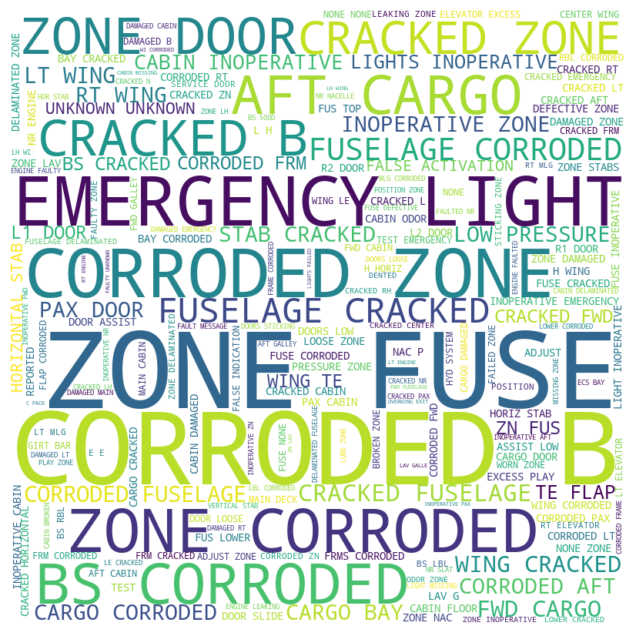

In [19]:
# Word cloud
from wordcloud import WordCloud
text = ' '.join(df['Part Failure'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Report

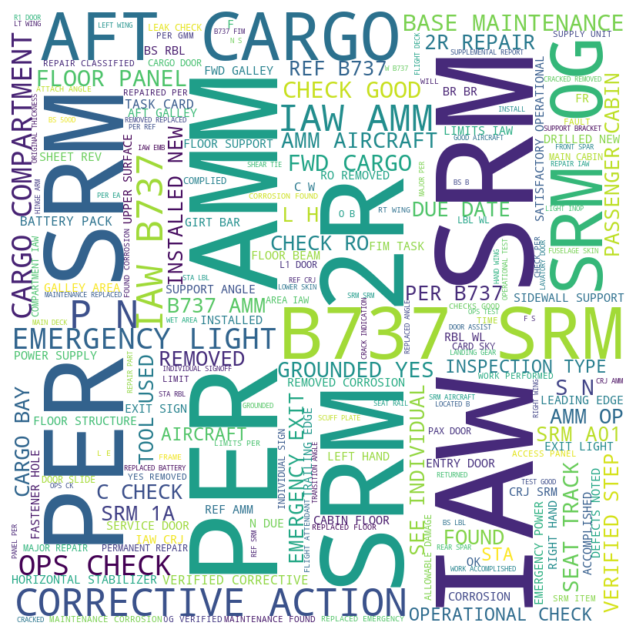

In [20]:
# word cloud of Reports
from wordcloud import WordCloud
text = ' '.join(df['Report'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing text Dataset

In [21]:
# Preprocess the text data
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Apply stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [22]:
df['Report'] = df['Report'].apply(preprocess_text)

In [23]:
df['Part Failure'] = df['Part Failure'].apply(preprocess_text)

In [24]:
df['Occurence Nature condition'] = df['Occurence Nature condition'].str.strip().str.lower()

In [25]:
df.head()

,Report,Part Failure,Occurence Nature condition,Occurence Precautionary Procedures
0,mechan land gear gnd fail msg takeoff emerg de...,rt mlg brake damag,warning indication,OTHER
1,nose land gear extend fulli approach seen insp...,zone 700 malfunct,warning indication,ABORTED APPROACH
2,left side hydraul system filter bowl assembl s...,hyd filter fail,other,ABORTED APPROACH
3,aircraft rollout normal land land gear indic l...,left collaps,other,OTHER
4,upon takeoff roll prior reach 80 knot pilot re...,zone 600 crack,warning indication,ABORTED TAKEOFF


# Models - to classify ' Occurence Nature condition '

In [26]:
# Split the data into training and testing sets
X = df[['Report', 'Part Failure']]
y = df['Occurence Nature condition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Create TF-IDF vectors for the text data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.apply(lambda x: ' '.join(x), axis=1))
X_test_vec = vectorizer.transform(X_test.apply(lambda x: ' '.join(x), axis=1))

In [28]:
# Train a linear SVM model
model = LinearSVC()
model.fit(X_train_vec, y_train)

LinearSVC()

In [29]:
# Make predictions on the train set
y_predtrain_SVC = cross_val_predict(estimator = model, X = X_train_vec, y = y_train, cv = 10)

# Make predictions on the test set
y_pred_SVC = model.predict(X_test_vec)

In [30]:
print('Validation Report (SVM):\n ', classification_report(y_train, y_predtrain_SVC, zero_division=True))

Validation Report (SVM):
                              precision    recall  f1-score   support

            affect systems       0.64      0.15      0.24       140
   elect. power loss-50 pc       0.60      0.13      0.21        23
           engine flameout       0.80      0.44      0.57        27
           engine stoppage       0.91      0.29      0.44        34
                    f.o.d.       0.73      0.36      0.48       130
             false warning       0.75      0.63      0.69      1179
                flame/fire       0.77      0.47      0.59        51
         flt cont affected       0.58      0.25      0.35       223
       flt. attitude inst.       1.00      0.13      0.24        15
                fluid loss       0.72      0.65      0.69       694
            inadequate q c       0.62      0.14      0.23       167
       inflight separation       1.00      0.17      0.29        36
          multiple failure       0.69      0.12      0.20        78
                   n

In [31]:
# Evaluate the performance of the model
print('Evaluation Report (SVM):\n', classification_report(y_test, y_pred_SVC, zero_division=True))

Evaluation Report (SVM):
                             precision    recall  f1-score   support

            affect systems       0.81      0.21      0.33        62
   elect. power loss-50 pc       1.00      0.00      0.00         4
           engine flameout       0.86      0.55      0.67        11
           engine stoppage       1.00      0.23      0.37        22
                    f.o.d.       0.74      0.41      0.53        61
             false warning       0.77      0.64      0.70       504
                flame/fire       0.56      0.36      0.43        14
         flt cont affected       0.65      0.32      0.43        97
       flt. attitude inst.       0.75      0.50      0.60         6
                fluid loss       0.73      0.65      0.68       281
            inadequate q c       0.67      0.21      0.32        56
       inflight separation       0.00      0.00      0.00        11
          multiple failure       0.91      0.34      0.50        29
                   no

Looking at the report, the model has a high accuracy of 92% which indicates that it is performing well in predicting the target variable. However, it is important to note that the class distribution is imbalanced as some classes have very few samples.

The precision metric shows the proportion of correctly predicted positive instances out of all instances predicted as positive, while recall shows the proportion of correctly predicted positive instances out of all actual positive instances. The F1-score is the harmonic mean of precision and recall.

For example, the class 'other' has a precision of 0.95, recall of 0.97, and F1-score of 0.96, indicating that the model is performing very well in predicting this class. 

On the other hand, the class 'inflight separation' has a precision of 0.0, recall of 0.0, and F1-score of 0.0, indicating that the model is not performing well in predicting this class.

Overall, the evaluation report shows that the SVM model is performing well in predicting the target variable, but there may be some classes that require further attention and improvement in performance.